In [7]:
import pandas as pd
import nltk.data
import warnings
import nltk.tokenize
from nltk.grammar import DependencyGrammar
from nltk.parse import (
    DependencyGraph,
    ProjectiveDependencyParser,
    NonprojectiveDependencyParser,
)
from zss import simple_distance, Node
import spacy
import numpy as np

In [2]:
nlp = spacy.load('en')

In [36]:
sents = open('all_sents.txt')

In [20]:
s1 = sents.readline().strip('\n')
s2 = sents.readline().strip('\n')

In [21]:
ps1 = nlp(s1)
ps2 = nlp(s2)

In [10]:
# ?ps2.print_tree()

In [3]:


def to_conll(sent):
    t = []
    for i, word in enumerate(sent):
#         if word.head is word:
#             head_idx = 0
#         else:
#              head_idx = word.i-sent[i].i+1
        head_idx = word.head.i+1
        t.append((
            str(i+1),
            word.lemma_,
            '_',# There's a word.i attr that's position in *doc*
            word.pos_,
            '_',# Coarse-grained tag
            word.tag_, # Fine-grained tag
            str(head_idx) if word.dep_ != 'ROOT' else str(0),
            word.dep_, # Relation
            '_', '_'))
    return '\n'.join(['\t'.join(s) for s in t])

In [40]:
ps1

Beneath the mantle are three major cortical appendages: the basal ganglia and cerebellum (both of which regulate movement), and the hippocampus, which is necessary for memory.

In [ ]:
f = open('trees_conll.txt', 'w')
for line in sents:
    l = line.strip('\n')
    doc = nlp(l)
    
    conll = to_conll(doc)
    f.write(conll+'\n\n')
f.close()

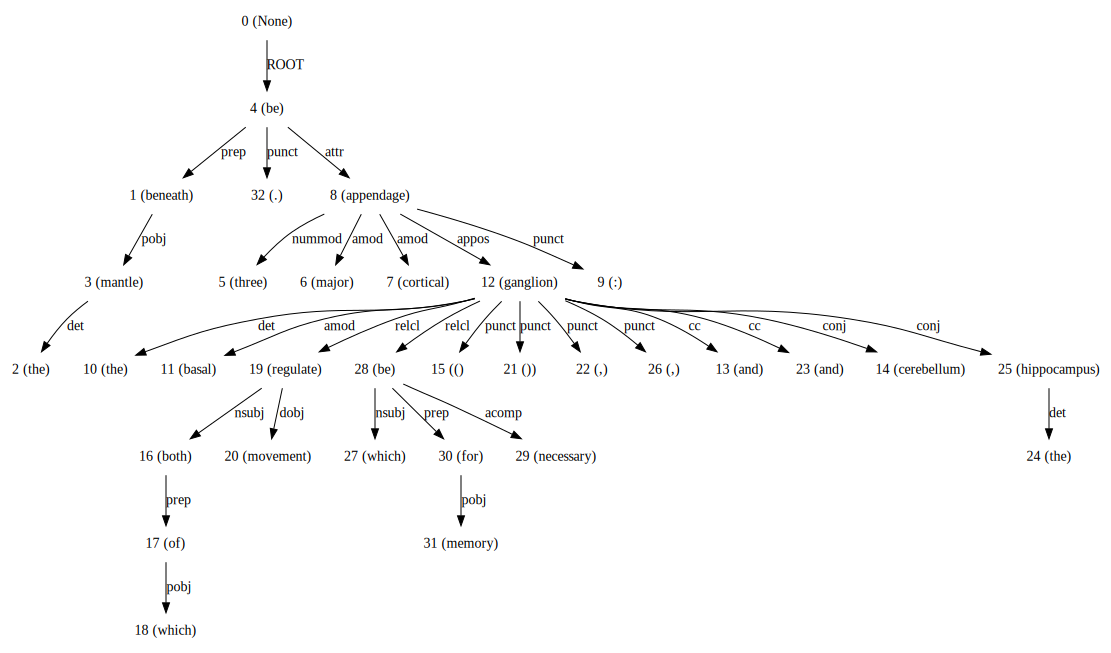

In [31]:
DependencyGraph(to_conll(ps1))

In [37]:
to_conll(ps1)

'1\tbeneath\t_\tADP\t_\tIN\t4\tprep\t_\t_\n2\tthe\t_\tDET\t_\tDT\t3\tdet\t_\t_\n3\tmantle\t_\tNOUN\t_\tNN\t1\tpobj\t_\t_\n4\tbe\t_\tVERB\t_\tVBP\t0\tROOT\t_\t_\n5\tthree\t_\tNUM\t_\tCD\t8\tnummod\t_\t_\n6\tmajor\t_\tADJ\t_\tJJ\t8\tamod\t_\t_\n7\tcortical\t_\tADJ\t_\tJJ\t8\tamod\t_\t_\n8\tappendage\t_\tNOUN\t_\tNNS\t4\tattr\t_\t_\n9\t:\t_\tPUNCT\t_\t:\t8\tpunct\t_\t_\n10\tthe\t_\tDET\t_\tDT\t12\tdet\t_\t_\n11\tbasal\t_\tNOUN\t_\tNN\t12\tamod\t_\t_\n12\tganglion\t_\tNOUN\t_\tNNS\t8\tappos\t_\t_\n13\tand\t_\tCCONJ\t_\tCC\t12\tcc\t_\t_\n14\tcerebellum\t_\tNOUN\t_\tNN\t12\tconj\t_\t_\n15\t(\t_\tPUNCT\t_\t-LRB-\t12\tpunct\t_\t_\n16\tboth\t_\tDET\t_\tDT\t19\tnsubj\t_\t_\n17\tof\t_\tADP\t_\tIN\t16\tprep\t_\t_\n18\twhich\t_\tADJ\t_\tWDT\t17\tpobj\t_\t_\n19\tregulate\t_\tVERB\t_\tVBP\t12\trelcl\t_\t_\n20\tmovement\t_\tNOUN\t_\tNN\t19\tdobj\t_\t_\n21\t)\t_\tPUNCT\t_\t-RRB-\t12\tpunct\t_\t_\n22\t,\t_\tPUNCT\t_\t,\t12\tpunct\t_\t_\n23\tand\t_\tCCONJ\t_\tCC\t12\tcc\t_\t_\n24\tthe\t_\tDET\t_\tDT\t25\

In [158]:
# Функции для превращения деревьев в формат, необходимый для tree adit distance (Zhu)
sp = []
def transform(tree):
    global sp
    sp = reshape(tree.nodes)
    return eval(parse(sp[0]))

def transform_raw(tree):
    global sp
    sp = reshape(tree.nodes)
    return parse(sp[0])

def reshape(d):
    sp = [(d[x]['rel'], [j for i in d[x]['deps'] for j in d[x]['deps'][i]]) for x in range(len(d))]
    return sp

def parse(tree):
    if len(tree[1]) == 0:
        return 'Node("{}", [])'.format(tree[0])
    else:
        return 'Node("{}", ['.format(tree[0]) + ','.join([parse(sp[x]) for x in tree[1]]) + '])'

In [159]:
transform_raw(DependencyGraph(trees[312]))


'Node("None", [Node("ROOT", [Node("nsubj", []),Node("dobj", [Node("relcl", [Node("dobj", [Node("prep", [Node("pobj", [])])]),Node("aux", [])]),Node("det", [])]),Node("prep", [Node("pobj", [Node("poss", [])])]),Node("punct", []),Node("punct", [])])])'

In [3]:
d = DependencyGraph(trees[312])

In [31]:
d.nodes[6]['deps']['nsubj'][0]

5

In [68]:
def get_subtree(nodes, node):
    if not nodes[node]['deps']:
        return [node]
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] for dep in nodes[node]['deps'][rel]]
# flatten = lambda l: [item for sublist in l for item in sublist]
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat
def get_predicate(d):
    subj = []
    main_subj = None
    obj = []
    main_obj = None
    verbs = []
    nodes = d.nodes
    for node in nodes:
        if nodes[node]['ctag'] == 'VERB':
            verb = [node]
            if 'aux' in nodes[node]['deps']:
                verb += flatten([get_subtree(nodes, n) for n in nodes[node]['deps']['aux']])
            verbs.append(verb)
    
    if not verbs:
#         print('BAD!')
        return None
    
    predicates = []
    for verb in verbs:
        if 'dobj' in nodes[verb[0]]['deps'] and 'nsubj' in nodes[verb[0]]['deps']:
            main_subj = nodes[verb[0]]['deps']['nsubj'][0]
            main_obj = nodes[verb[0]]['deps']['dobj'][0]
    
            subj = sorted(flatten(get_subtree(nodes, main_subj)))
            obj = sorted(flatten(get_subtree(nodes, main_obj)))
    
            subj_words = [nodes[node]['word'] for node in subj]
            obj_words = [nodes[node]['word'] for node in obj]
            verb_words = [nodes[node]['word'] for node in sorted(verb)]

            predicates.append((' '.join(subj_words), ' '.join(verb_words), ' '.join(obj_words)))
    
    return predicates
    

In [78]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>>,
            {0: {'address': 0,
              'ctag': 'TOP',
              'deps': defaultdict(list, {}),
              'feats': None,
              'head': None,
              'lemma': None,
              'rel': None,
              'tag': 'TOP',
              'word': None}})

In [79]:
lang_facts = []
for tree in trees:
    try:
        d = DependencyGraph(tree)
    except:
        continue
    pr = get_predicate(d)
    if not pr:continue
    for p in pr:
#         if 'language' in p[0] and 'have' in p[1]:
#             lang_facts.append(p)
        if 'russian' in ''.join([p[0], p[2]]):
            lang_facts.append(p)
    

In [80]:
lang_facts

[('-PRON-',
  'take',
  'the two contact language ( ndyuka and chinese pidgin russian , both lack classifier )'),
 ("russian the numeral ‘ two’ , ' three’ and ‘ four’",
  'govern',
  'the genitive case and singular number'),
 ('1998:â•›96 ) approximation through word order east slavic language',
  'have',
  'the typologically very rare strategy of express approximation ( ‘ about x , roughly x’ ) by invert the word order of numeral and noun : russian ( indo - european ( slavic ) : russia ) a.'),
 ('-PRON-',
  'include',
  '5 slavic language ( bulgarian , czech , russian , slovak , slovenian ) , 5 romance language ( catalan , spanish , italian , portuguese , romanian ) , 5 germanic language ( danish , german , english , dutch , swedish ) , 3 indo - iranian language ( bengali , persian , hindi ) , 2 hellenic language ( greek , ancient greek ) , and 1 italic language ( latin )'),
 ('russian numeral', 'govern', 'a case'),
 ('russian preposition', 'govern', 'all case but the nominative'),
 (

In [160]:
[x.split('\t') for x in trees[312].split('\n')]

[['1', 'in', '_', 'ADP', '_', 'IN', '6', 'prep', '_', '_'],
 ['2', '-PRON-', '_', 'ADJ', '_', 'PRP$', '3', 'poss', '_', '_'],
 ['3', 'place', '_', 'NOUN', '_', 'NN', '1', 'pobj', '_', '_'],
 ['4', ',', '_', 'PUNCT', '_', ',', '6', 'punct', '_', '_'],
 ['5', '-PRON-', '_', 'PRON', '_', 'PRP', '6', 'nsubj', '_', '_'],
 ['6', 'propose', '_', 'VERB', '_', 'VBP', '0', 'ROOT', '_', '_'],
 ['7', 'a', '_', 'DET', '_', 'DT', '8', 'det', '_', '_'],
 ['8', 'program', '_', 'NOUN', '_', 'NN', '6', 'dobj', '_', '_'],
 ['9', 'to', '_', 'PART', '_', 'TO', '10', 'aux', '_', '_'],
 ['10', 'promote', '_', 'VERB', '_', 'VB', '8', 'relcl', '_', '_'],
 ['11', 'excellence', '_', 'NOUN', '_', 'NN', '10', 'dobj', '_', '_'],
 ['12', 'in', '_', 'ADP', '_', 'IN', '11', 'prep', '_', '_'],
 ['13', 'reasoning', '_', 'NOUN', '_', 'NN', '12', 'pobj', '_', '_'],
 ['14', '.', '_', 'PUNCT', '_', '.', '6', 'punct', '_', '_']]

In [35]:
simple_distance(ztree1,ztree2)

31

In [8]:
trees = open('trees_conll.txt').read().split('\n\n')

In [1]:
rels = set()
poss = set()
for tree in trees:
    try:
        labels = [x.split('\t')[7] for x in tree.split('\n')]
        pos = [x.split('\t')[3] for x in tree.split('\n')]
    except Exception as e:
        print(e)
        continue
    rels.update(labels)
    poss.update(pos)

NameError: name 'trees' is not defined

In [111]:
from string import ascii_letters as letters
from string import digits

In [115]:
letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [110]:
len('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRST')

46

In [116]:
letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRST'
digits = '0123456789UVWXYZ'

rel2id = {rel:letters[i] for i, rel in enumerate(rels)}
pos2id = {pos:digits[i] for i, pos in enumerate(poss)}

In [139]:
rel2id = {'': 'a',
 'ROOT': 'w',
 'acl': 'u',
 'acomp': 'm',
 'advcl': 'O',
 'advmod': 'k',
 'agent': 'D',
 'amod': 'b',
 'appos': 'C',
 'attr': 'o',
 'aux': 'B',
 'auxpass': 'r',
 'case': 'e',
 'cc': 'v',
 'ccomp': 'AAA',
 'compound': 'M',
 'conj': 'q',
 'csubj': 'JJJ',
 'csubjpass': 'P',
 'dative': 'p',
 'dep': 's',
 'det': 'R',
 'dobj': 'GGG',
 'expl': 'n',
 'intj': 'y',
 'mark': 'h',
 'meta': 'g',
 'neg': 'x',
 'nmod': 'E',
 'npadvmod': 'N',
 'nsubj': 'FFF',
 'nsubjpass': 'T',
 'nummod': 'j',
 'oprd': 'I',
 'parataxis': 'Q',
 'pcomp': 'l',
 'pobj': 'KK',
 'poss': 'd',
 'preconj': 'S',
 'predet': 'c',
 'prep': 'H',
 'prt': 'L',
 'punct': 'i',
 'quantmod': 'z',
 'relcl': 't',
 'xcomp': 'fff'}

In [119]:
# [x.split('\t') for x in trees[1].split('\n')]

In [141]:
f =  open('similarities.txt', 'w')
errors = 0
skipped = []
for i in np.random.choice(range(len(trees)), 1000, replace=False):
#     if not i % 1000:
#         print('i - ', i)
    tr1 = []
    t1 = [x.split('\t') for x in trees[i].split('\n')]
    tags1 = set([x[3] for x in t1])
    if len(tags1) < 5 or len(t1) < 10:
        continue
    
    for ind, word, _, pos, _, _, head, rel, _, _ in t1:
#         if not rel:
#             rel = 'shit'
        if word == '  ':
            word = '<SHIT>'
        tr1.append('\t'.join([word, pos2id[pos], head, rel2id[rel]]))

    try:
        ztr1 = transform(DependencyGraph('\n'.join(tr1)))
    except:
        skipped.append(i)
        continue

    for j in np.random.choice(range(len(trees)), 100, replace=False):
        if j == i:
            continue 
        tr2 = []
        t2 = [x.split('\t') for x in trees[j].split('\n')]
        tags2 = set([x[3] for x in t2])
        
        if abs(len(t1) - len(t2)) > 10:
            continue
        
        if len(tags2) < 5:
            continue
        if abs(len(tags1) - len(tags2)) > 7:
            continue
        for ind, word, _, pos, _, _, head, rel, _, _ in t2:
#             if not rel:
#                 rel = 'shit'
            if word == '  ':
                word = '<SHIT>'
            tr2.append('\t'.join([word, pos2id[pos], head, rel2id[rel]]))

        try:
            ztr2 = transform(DependencyGraph('\n'.join(tr2)))
        except:
            errors += 1
            continue
        
        d = simple_distance(ztr1, ztr2)
        f.write('\t'.join([str(i), str(j), str(d), str(len(t1)), str(len(t2)), str(d/min([len(tr1), len(tr2)]))])+'\n')


/usr/local/lib/python3.5/dist-packages/nltk/parse/dependencygraph.py:380: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


In [142]:
f.close()

In [152]:
list(ztr1.iter())

[<zss.simple_tree.Node object at 0x7f93ec11dc50 None>,
 <zss.simple_tree.Node object at 0x7f93ec11def0 w>,
 <zss.simple_tree.Node object at 0x7f93ec19c198 i>,
 <zss.simple_tree.Node object at 0x7f93ec19c358 i>,
 <zss.simple_tree.Node object at 0x7f93ec11ddd8 fff>,
 <zss.simple_tree.Node object at 0x7f93ec11d7b8 FFF>,
 <zss.simple_tree.Node object at 0x7f93ec11dba8 O>,
 <zss.simple_tree.Node object at 0x7f93ec11d780 GGG>,
 <zss.simple_tree.Node object at 0x7f93ec11d6a0 B>,
 <zss.simple_tree.Node object at 0x7f93ec11de10 b>,
 <zss.simple_tree.Node object at 0x7f93ec11d6d8 H>,
 <zss.simple_tree.Node object at 0x7f93ec11d898 R>,
 <zss.simple_tree.Node object at 0x7f93ec11d390 B>,
 <zss.simple_tree.Node object at 0x7f93ec11da20 o>,
 <zss.simple_tree.Node object at 0x7f93ec11deb8 t>,
 <zss.simple_tree.Node object at 0x7f93ec11db00 KK>,
 <zss.simple_tree.Node object at 0x7f93ec11d940 c>,
 <zss.simple_tree.Node object at 0x7f93ec11df60 R>,
 <zss.simple_tree.Node object at 0x7f93ec11d748 D>,
 <

In [157]:
ztr1.get_children(ztr1.get('FFF'))

[<zss.simple_tree.Node object at 0x7f93ec11de10 b>,
 <zss.simple_tree.Node object at 0x7f93ec11d6d8 H>,
 <zss.simple_tree.Node object at 0x7f93ec11d898 R>]

In [146]:
[x.split('\t') for x in trees[152784].split('\n')]

[['1', 'bolstad', '_', 'PROPN', '_', 'NNP', '5', 'nsubj', '_', '_'],
 ['2', '(', '_', 'PUNCT', '_', '-LRB-', '1', 'punct', '_', '_'],
 ['3', '2002', '_', 'NUM', '_', 'CD', '1', 'appos', '_', '_'],
 ['4', ')', '_', 'PUNCT', '_', '-RRB-', '1', 'punct', '_', '_'],
 ['5', 'provide', '_', 'VERB', '_', 'VBZ', '0', 'ROOT', '_', '_'],
 ['6', 'a', '_', 'DET', '_', 'DT', '8', 'det', '_', '_'],
 ['7', 'comprehensive', '_', 'ADJ', '_', 'JJ', '8', 'amod', '_', '_'],
 ['8', 'reference', '_', 'NOUN', '_', 'NN', '5', 'dobj', '_', '_'],
 ['9', 'to', '_', 'ADP', '_', 'IN', '8', 'prep', '_', '_'],
 ['10', 'these', '_', 'DET', '_', 'DT', '9', 'pobj', '_', '_'],
 ['11', 'in', '_', 'ADP', '_', 'IN', '5', 'prep', '_', '_'],
 ['12', '-PRON-', '_', 'ADJ', '_', 'PRP$', '13', 'poss', '_', '_'],
 ['13', 'work', '_', 'NOUN', '_', 'NN', '11', 'pobj', '_', '_'],
 ['14', '.', '_', 'PUNCT', '_', '.', '5', 'punct', '_', '_']]

In [145]:
[x.split('\t') for x in trees[222835].split('\n')]

[['1', 'other', '_', 'NOUN', '_', 'NNS', '6', 'nsubj', '_', '_'],
 ['2', '(', '_', 'PUNCT', '_', '-LRB-', '1', 'punct', '_', '_'],
 ['3', 'most', '_', 'ADJ', '_', 'JJS', '4', 'amod', '_', '_'],
 ['4', 'americans', '_', 'PROPN', '_', 'NNPS', '1', 'appos', '_', '_'],
 ['5', ')', '_', 'PUNCT', '_', '-RRB-', '1', 'punct', '_', '_'],
 ['6', 'pronounce', '_', 'VERB', '_', 'VBP', '0', 'ROOT', '_', '_'],
 ['7', 'a', '_', 'DET', '_', 'DT', '10', 'det', '_', '_'],
 ['8', 'very', '_', 'ADV', '_', 'RB', '9', 'advmod', '_', '_'],
 ['9', 'short', '_', 'ADJ', '_', 'JJ', '10', 'amod', '_', '_'],
 ['10', 'vowel', '_', 'NOUN', '_', 'NN', '6', 'dobj', '_', '_'],
 ['11', 'in', '_', 'ADP', '_', 'IN', '6', 'prep', '_', '_'],
 ['12', 'the', '_', 'DET', '_', 'DT', '14', 'det', '_', '_'],
 ['13', 'second', '_', 'ADJ', '_', 'JJ', '14', 'amod', '_', '_'],
 ['14', 'syllable', '_', 'NOUN', '_', 'NN', '11', 'pobj', '_', '_'],
 ['15', '.', '_', 'PUNCT', '_', '.', '6', 'punct', '_', '_']]

In [131]:
?simple_distance(ztr1, ztr2)

In [17]:
[len(x.split('\t')) for x in trees[j].split('\n')]

[10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

In [19]:
trees[j]

'1\t--\t_\tPUNCT\t_\t\t0\tROOT\t_\t_\n2\tj.\t_\tPROPN\t_\tNNP\t5\tcompound\t_\t_\n3\tb.\t_\tPROPN\t_\tNNP\t5\tcompound\t_\t_\n4\ts.\t_\tPROPN\t_\tNNP\t5\tcompound\t_\t_\n5\thaldane\t_\tPROPN\t_\tNNP\t6\tcompound\t_\t_\n6\t03edelmanch03.023_034\t_\tADP\t_\tIN\t0\tROOT\t_\t_\n7\t7/22/06\t_\tNUM\t_\tCD\t0\tROOT\t_\t_\n8\t1:55\t_\tNUM\t_\tCD\t9\tnummod\t_\t_\n9\tpm\t_\tNOUN\t_\tNN\t0\tROOT\t_\t_\n10\tpage\t_\tNOUN\t_\tNN\t0\tROOT\t_\t_\n11\t23\t_\tNUM\t_\tCD\t10\tnummod\t_\t_\n12\tt\t_\tNOUN\t_\tNN\t13\tcompound\t_\t_\n13\th\t_\tNOUN\t_\tNN\t10\tpunct\t_\t_\n14\te\t_\tNOUN\t_\tNN\t17\tcompound\t_\t_\n15\td\t_\tNOUN\t_\tNN\t17\tcompound\t_\t_\n16\te\t_\tNOUN\t_\tNN\t17\tcompound\t_\t_\n17\ts\t_\tNOUN\t_\tNN\t0\tROOT\t_\t_\n18\tc\t_\tNOUN\t_\tNN\t19\tcompound\t_\t_\n19\tr\t_\tNOUN\t_\tNN\t0\tROOT\t_\t_\n20\ti\t_\tNOUN\t_\tNN\t22\tcompound\t_\t_\n21\tp\t_\tNOUN\t_\tNN\t22\tcompound\t_\t_\n22\tt\t_\tNOUN\t_\tNN\t0\tROOT\t_\t_\n23\t-PRON-\t_\tPRON\t_\tPRP\t0\tROOT\t_\t_\n24\to\t_\tINTJ\t_\tUH\t